# Quality Control and ASV table construction with DADA2

## Setup and settings

In [1]:
# Importing packages
import os
import yaml
import logging
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.dada2.actions as dada2_actions
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.feature_table.visualizers import tabulate_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.visualizers import core_features

import matplotlib.pyplot as plt

%matplotlib inline

### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [2]:
experiment_name = 'ana-flavia-superlactacao'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'redemicro')
metadata_file = os.path.join(base_dir, 'data', 'raw', 'metadata', 'sample-metadata.tsv')
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = None

In [3]:
# Parameters
experiment_name = "ana-flavia-HSD-NCxHSD-NR-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-HSD-NCxHSD-NR.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-HSD-NCxHSD-NR.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/dados_brutos_rede_genoma/16S_classifiers_qiime2/silva-138-99-nb-classifier.qza"
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


In [4]:
# Setting hardcoded parameters for development and debbuging
production = True
if not production:
    params_path = os.path.join('..', 'params', 'ana-flavia-superlactacao.yaml')
    with open(params_path, 'r') as stream:
        params = yaml.safe_load(stream)
        experiment_name = params['experiment_name']
        base_dir = params['base_dir']
        replace_files = params['replace_files']
        experiment_folder = os.path.abspath(os.path.join(os.getcwd(), '..', 'experiments', 'thayane-feces-01'))
        img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
        replace_files = False
        phred = 20
        trunc_f = 0
        trunc_r = 0
        overlap = 12
        threads = 6

In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))

### Defining names and paths

In [6]:
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

if trim:
    demux_file = os.path.join(qiime_folder, 'demux-paired-trim.qza')
else:
    demux_file = os.path.join(qiime_folder, 'demux-paired.qza')

dada2_tabs = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat = os.path.join(qiime_folder, 'dada2-stat.qza')


dada2_tabs_view = dada2_tabs[:-1] + 'v'
dada2_reps_view = dada2_reps[:-1] + 'v'
dada2_stat_view = dada2_stat[:-1] + 'v'
dada2_core_view = os.path.join(qiime_folder, 'dada2-core.qzv')

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [7]:
need_dada2 = not (os.path.isfile(dada2_tabs) and os.path.isfile(dada2_reps) and os.path.isfile(dada2_stat)) or replace_files
need_view = not (os.path.isfile(dada2_tabs_view) and os.path.isfile(dada2_reps_view) and os.path.isfile(dada2_stat_view)) or replace_files

In [8]:
if need_dada2:
    demux = Artifact.load(demux_file)

In [9]:
metadata = Metadata.load(metadata_file)

### Execute DADA2 plugin and create Artifacts

The DADA2 plugin perform tha quality control and create the ASV table. It will be produced three Artifacts:

- tabs (`FeatureTable[Frequency]`) : 
    The resulting feature table.
- reps (`FeatureData[Sequence]`) :
    The resulting feature sequences. Each feature in the feature table will
    be represented by exactly one sequence, and these sequences will be the
    joined paired-end sequences.
- denoising_stats (`SampleData[DADA2Stats]`) : the resulting stats. Shows the number and the proportion of filtered reads in each phase of the plugin execution.

In [10]:
# If some of the DADA2 outputs artifacts do not exist or if the old files will be replaced
if need_dada2:
    
    # Excute the DADA2 plugin
    tabs, reps, stat = dada2_actions.denoise_paired(
        demultiplexed_seqs=demux,
        trunc_q = phred,
        min_overlap = overlap,
        n_threads = threads,
        trunc_len_f = trunc_f,
        trunc_len_r = trunc_r,
    )
    
    # Save the artifacts objects
    tabs.save(dada2_tabs)
    reps.save(dada2_reps)
    stat.save(dada2_stat)

else:
    tabs = Artifact.load(dada2_tabs)
    reps = Artifact.load(dada2_reps)
    stat = Artifact.load(dada2_stat)

### Define Visualizations Artifacts

In [11]:
# If some of the DADA2 Visualization artifacts do not exist or if the old files will be replaced
if need_view:
    
    tabs_view, = metadata_actions.tabulate(input=tabs.view(Metadata))
    reps_view, = metadata_actions.tabulate(input=reps.view(Metadata))
    stat_view, = metadata_actions.tabulate(input=stat.view(Metadata))
    
    tabs_view = summarize(table=tabs, sample_metadata=metadata).visualization
    reps_view = tabulate_seqs(data=reps).visualization
    core_view = core_features(table=tabs, min_fraction=.1, steps=10).visualization
    
    
    # Save the artifacts objects
    tabs_view.save(dada2_tabs_view)
    reps_view.save(dada2_reps_view)
    stat_view.save(dada2_stat_view)
    core_view.save(dada2_core_view)

else:
    tabs_view = Visualization.load(dada2_tabs_view)
    reps_view = Visualization.load(dada2_reps_view)
    stat_view = Visualization.load(dada2_stat_view)
    core_view = Visualization.load(dada2_core_view)

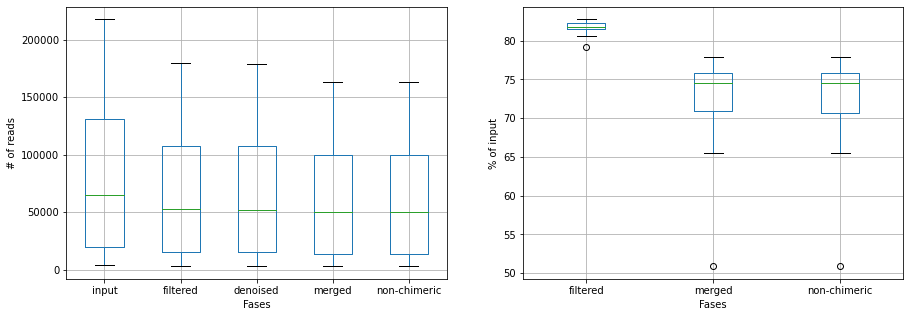

In [12]:
def plot_stats_box(artifact, fname):
    import matplotlib.pyplot as plt
    from qiime2 import Metadata
    
    values_head = ['input', 'filtered', 'denoised', 'merged', 'non-chimeric']
    percent_head = ['percentage of input passed filter', 'percentage of input merged', 'percentage of input non-chimeric']
    
    df = artifact.view(Metadata).to_dataframe()
    df_vals = df[values_head]
    df_perc = df[percent_head]
    df_perc.columns = ['filtered', 'merged', 'non-chimeric']
    
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    df_vals.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('# of reads')
    
    plt.subplot(1, 2, 2)
    df_perc.boxplot()
    plt.xlabel('Fases')
    plt.ylabel('% of input')
    
    plt.savefig(fname, bbox_inches='tight')

    plt.show()

plot_stats_box(stat, os.path.join(img_folder, 'step02-stats-boxplot.pdf'))

In [13]:
percent_head = ['percentage of input passed filter', 'percentage of input merged', 'percentage of input non-chimeric']
stat.view(Metadata).to_dataframe().describe()[percent_head]

,percentage of input passed filter,percentage of input merged,percentage of input non-chimeric
count,15.000000,15.000000,15.000000
mean,81.645333,72.050667,71.974667
std,0.899141,6.883319,6.874845
min,79.150000,50.860000,50.860000
25%,81.510000,70.915000,70.720000
50%,81.710000,74.490000,74.490000
75%,82.235000,75.825000,75.820000
max,82.760000,77.900000,77.890000


In [14]:
stat_view

<visualization: Visualization uuid: 231493e6-5c28-4ee6-b95c-d14261adfc63>

In [15]:
# new_stat = Artifact.load('/home/lauro/nupeb/redemicro/experiments/thayane-feces-01/qiime-artifacts/dada2-stat.qza')
# # new_view, = metadata_actions.tabulate(input=new_stat.view(Metadata))
# # plot_stats_box(old_stat)

# old_stat = Artifact.load('/home/lauro/nupeb/dados_brutos_rede_genoma/experiments/fezes-phred_20-tf_0-tr_0-lap_4/fezes_dada2_stat.qza')
# # old_view, = metadata_actions.tabulate(input=old_stat.view(Metadata))
# # plot_stats_box(old_stat)

# plot_stats_box_pairs(old_stat, new_stat)